## Задача исследования

The SMS Spam Collection представляет собой набор SMS-сообщений, собранных для исследования SMS-спама. Он содержит выборки SMS-сообщений на английском языке, помеченных в соответствии с тем, являются ли они спамом или нет. Наша задача состоит в проектировании модели, способной определять наличие спама в пришедшем письме.

**Анализ текста**

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

plt.style.use('ggplot')
sns.set_style('whitegrid')

plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['patch.force_edgecolor'] = True

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize

import spacy
nlp = spacy.load("en_core_web_sm")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
messages = pd.read_csv("/content/drive/MyDrive/homeworks/spam.csv", encoding = 'latin-1')

messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["category", "text"]

In [23]:
display(messages.head(n = 10))

,category,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [24]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  5572 non-null   object
 1   text      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


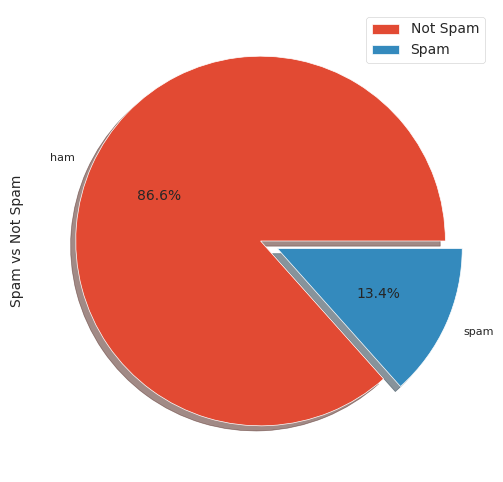

In [25]:
messages["category"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Not Spam")
plt.legend(["Not Spam", "Spam"])
plt.show()

86% датасета - не спам


##### Lets see the top spam/ham messages

In [26]:
topMessages = messages.groupby("text")["category"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 10)
display(topMessages)

,len,amax
text,,
"Sorry, I'll call later",30,ham
I cant pick the phone right now. Pls send a message,12,ham
Ok...,10,ham
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4,ham
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4,ham
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed å£1000 cash or å£5000 prize!,4,spam
Okie,4,ham
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4,ham
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st \Ur Lovely Friendship\""... good morning dear""",4,ham


Исследование популярных слов и слов-триггеров

In [27]:
import nltk
nltk.download('punkt')

spam_messages = messages[messages["category"] == "spam"]["text"]
ham_messages = messages[messages["category"] == "ham"]["text"]

spam_words = []
ham_words = []

def extractSpamWords(spamMessages):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam_words = spam_words + words

def extractHamWords(hamMessages):
    global ham_words
    words = [word.lower() for word in word_tokenize(hamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    ham_words = ham_words + words

spam_messages.apply(extractSpamWords)
ham_messages.apply(extractHamWords)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0       None
1       None
3       None
4       None
6       None
        ... 
5565    None
5568    None
5569    None
5570    None
5571    None
Name: text, Length: 4825, dtype: object

In [28]:
from wordcloud import WordCloud

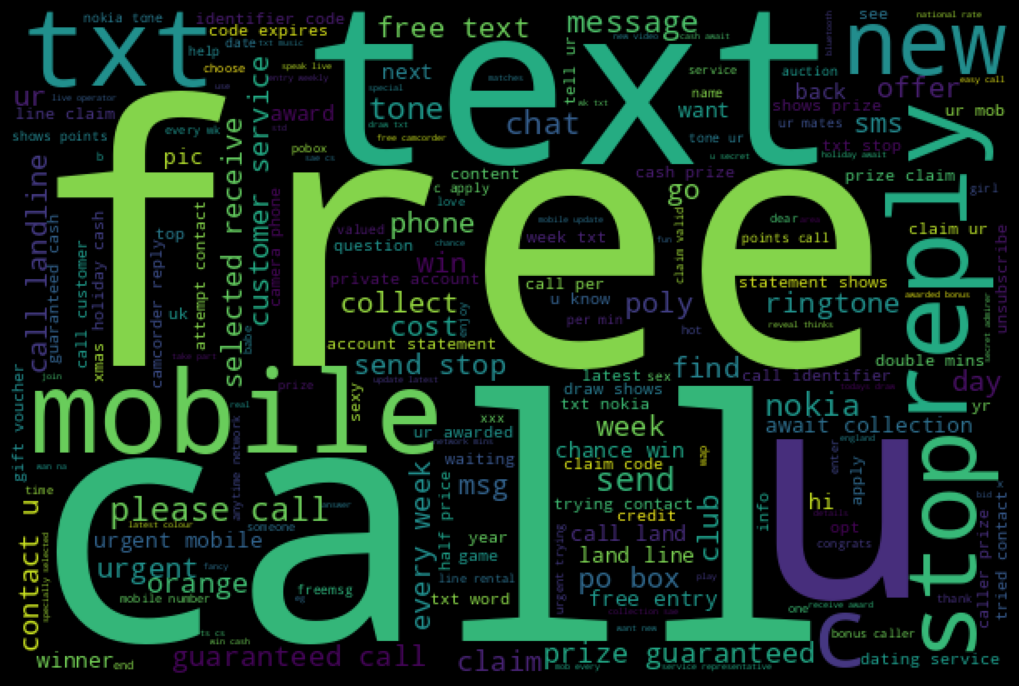

In [29]:
spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

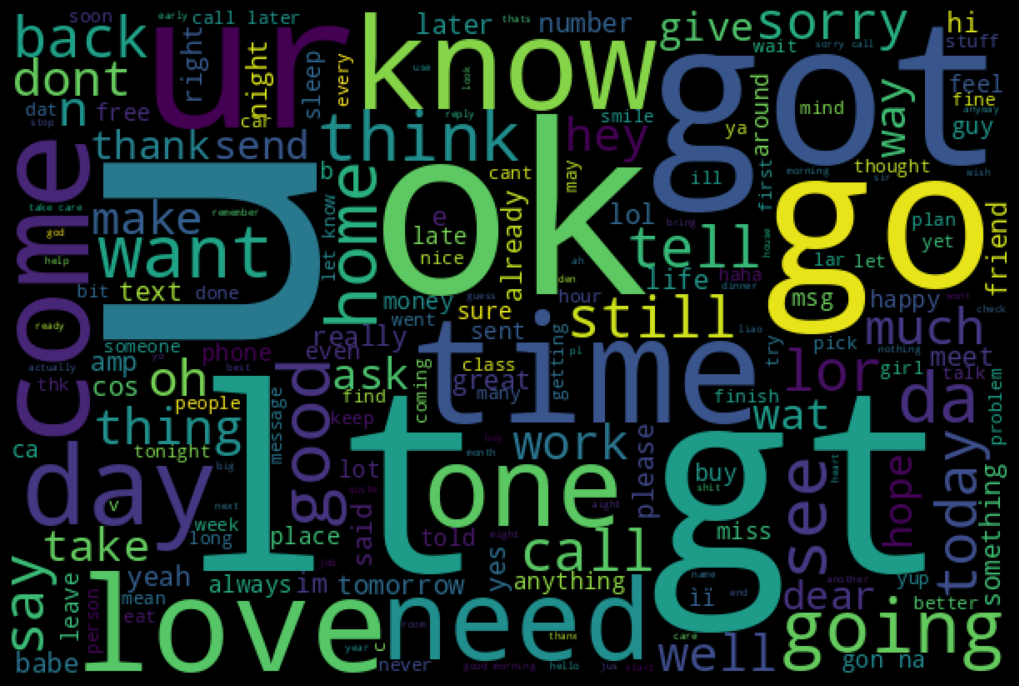

In [30]:
ham_wordcloud = WordCloud(width=600, height=400).generate(" ".join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [32]:
spam_words = np.array(spam_words)
print("Топ 10 спам-слов :\n")
pd.Series(spam_words).value_counts().head(n = 10)

Топ 10 спам-слов :



call      346
free      219
txt       156
u         144
ur        144
mobile    123
text      121
stop      114
claim     113
reply     104
dtype: int64

In [33]:
ham_words = np.array(ham_words)
print("Tоп 10 не спам-слов :\n")
pd.Series(ham_words).value_counts().head(n = 10)

Tоп 10 не спам-слов :



u       989
gt      318
lt      316
get     301
ok      261
go      248
got     242
ur      237
know    236
like    231
dtype: int64

Проверка влияния длины сообщений на характер письма

In [34]:
messages["messageLength"] = messages["text"].apply(len)
messages["messageLength"].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: messageLength, dtype: float64

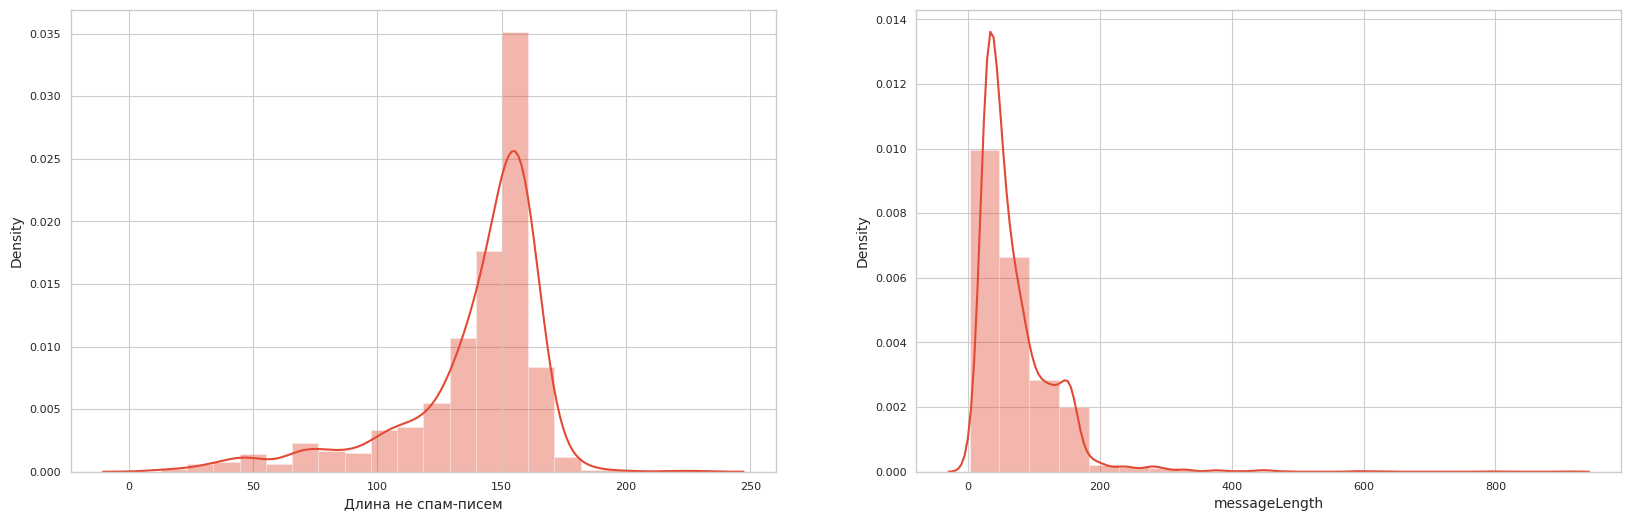

In [35]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

sns.distplot(messages[messages["category"] == "spam"]["messageLength"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Длина спам-писем")

sns.distplot(messages[messages["category"] == "ham"]["messageLength"], bins = 20, ax = ax[1])
ax[0].set_xlabel("Длина не спам-писем")

plt.show()

Спам-письма обычно длинее

**Трансформация текста**

In [36]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

def cleanText(message):

    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]

    return " ".join(words)

messages["text"] = messages["text"].apply(cleanText)
messages.head(n = 10)

,category,text,messageLength
0,ham,go jurong point crazi avail bugi n great world...,111
1,ham,ok lar joke wif u oni,29
2,spam,free entri 2 wkli comp win fa cup final tkts 2...,155
3,ham,u dun say earli hor u c alreadi say,49
4,ham,nah dont think goe usf live around though,61
5,spam,freemsg hey darl 3 week word back id like fun ...,148
6,ham,even brother like speak treat like aid patent,77
7,ham,per request mell mell oru minnaminungint nurun...,160
8,spam,winner valu network custom select receivea å£9...,158
9,spam,mobil 11 month u r entitl updat latest colour ...,154


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode", stop_words = "english")
features = vec.fit_transform(messages["text"])
print(features.shape)

(5572, 7903)


**Обучение модели**

In [38]:
def encodeCategory(cat):
    if cat == "spam":
        return 1
    else:
        return 0

messages["category"] = messages["category"].apply(encodeCategory)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, messages["category"], stratify = messages["category"], test_size = 0.2)

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score

from sklearn.naive_bayes import MultinomialNB
gaussianNb = MultinomialNB()
gaussianNb.fit(X_train, y_train)

y_pred = gaussianNb.predict(X_test)

print(fbeta_score(y_test, y_pred, beta = 0.5))

0.9082568807339451


Модель Наивного Байеса на тестовой выборке показала результат метрики F-beta score - 0.91